# Luenberger Observer

## System Definition

$$
x(k+1) = Ax(k)+Bu(k),\quad x\in\mathbb{R}^{10}
$$
$$
y(k) = Cx(k)+Du(k),\quad y\in\mathbb{R}^{3}
$$

## Observer Design

$$
\hat{x}(k+1) = A\hat{x}(k)+B u(k)+L\left(y(k)-\hat{y}(k)\right)
$$

A_poles: [ 0.29880611 -0.08317504  0.3896271   0.91620227 -0.1408586  -0.14084872
  0.95        0.46166228 -0.28241961  0.32638542]


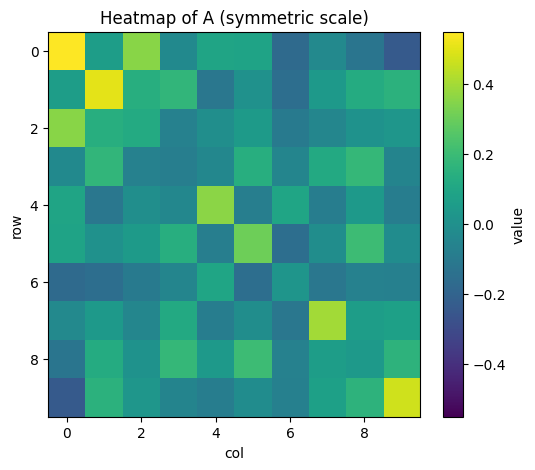

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 10
p = 3
m = 3

np.random.seed(42)
A_poles = np.random.randn(10)
A_poles = A_poles / np.max(np.abs(A_poles))*0.95
print("A_poles:", A_poles)

Q, _ = np.linalg.qr(np.random.randn(n, n))
A = Q @ np.diag(A_poles) @ Q.T

v = np.max(np.abs(A))
plt.figure(figsize=(6,5))
plt.imshow(A, vmin=-v, vmax=v, aspect="auto")
plt.colorbar(label="value")
plt.title("Heatmap of A (symmetric scale)")
plt.xlabel("col")
plt.ylabel("row")
plt.show()





In [2]:
def ctrb(A, B):
    n = A.shape[0]
    M = B
    Ak = np.eye(n)
    for _ in range(1, n):
        Ak = Ak @ A
        M = np.hstack([M, Ak @ B])
    return M

def obsv(A, C):
    n = A.shape[0]
    M = C
    Ak = np.eye(n)
    for _ in range(1, n):
        Ak = Ak @ A
        M = np.vstack([M, C @ Ak])
    return M

while True:
    B = np.random.randn(n, m)
    C = np.random.randn(p, n)
    if np.linalg.matrix_rank(ctrb(A, B)) == n and np.linalg.matrix_rank(obsv(A, C)) == n:
        break

print("rank(ctrb) =", np.linalg.matrix_rank(ctrb(A, B)))
print("rank(obsv) =", np.linalg.matrix_rank(obsv(A, C)))

D = np.zeros((p, m))

rank(ctrb) = 10
rank(obsv) = 10


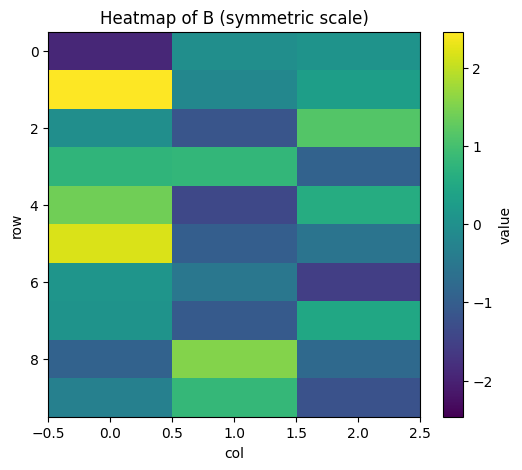

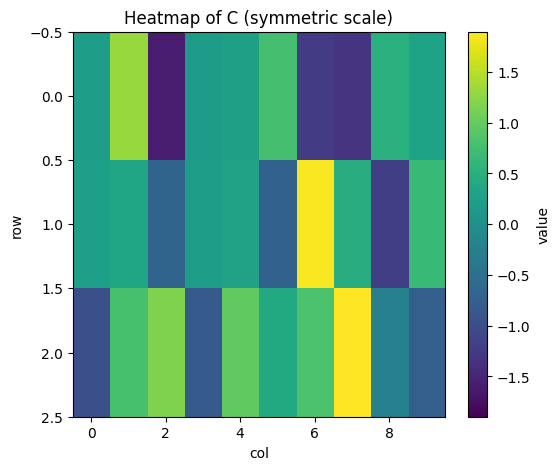

In [3]:
v_B = np.max(np.abs(B))
plt.figure(figsize=(6,5))
plt.imshow(B, vmin=-v_B, vmax=v_B, aspect="auto")
plt.colorbar(label="value")
plt.title("Heatmap of B (symmetric scale)")
plt.xlabel("col")
plt.ylabel("row")
plt.show()

v_C = np.max(np.abs(C))
plt.figure(figsize=(6,5))
plt.imshow(C, vmin=-v_C, vmax=v_C, aspect="auto")
plt.colorbar(label="value")
plt.title("Heatmap of C (symmetric scale)")
plt.xlabel("col")
plt.ylabel("row")
plt.show()

In [4]:
def simulate_system(A, B, C, D, x_0, U, Q = None, R = None, seed = 0):
    """
    Simulate the discrete-time LTI system:
        x_{k+1} = A x_k + B u_k + w_k,   w_k ~ N(0, Q)
        y_k     = C x_k + D u_k + v_k,   v_k ~ N(0, R)
    Inputs:
        A, B, C, D: system matrices
        x_0: initial state (n x 1)
        U: input sequence (N x m)
        Q: process noise covariance (n x n)
        R: measurement noise covariance (p x p)
        seed: random seed for reproducibility
    Outputs:
        X: state trajectory (N+1 x n)
        Y: output trajectory (N x p)
    """

    rng = np.random.default_rng(seed)
    n = A.shape[0]
    p = C.shape[0]
    T = U.shape[0]

    X = np.zeros((T+1, n))
    Y = np.zeros((T, p))
    X[0] = x_0

    for k in range(T):
        w = rng.multivariate_normal(np.zeros(n), Q) if Q is not None else 0.0
        v = rng.multivariate_normal(np.zeros(p), R) if R is not None else 0.0

        Y[k] = C @ X[k] + D @ U[k] + v
        X[k+1] = A @ X[k] + B @ U[k] + w

    return X, Y

"""
Simulation
"""

T = 50
n = 10
p = 3
m = 3

x_0 = np.random.randn(n)

U = np.random.choice([-1, 0, 1], size=(T, m), p=[0.1, 0.8, 0.1])

Q = 1e-4 * np.eye(n)
R = 1e-3 * np.eye(p)

X, Y = simulate_system(A, B, C, D, x_0, U, Q, R, seed=42)

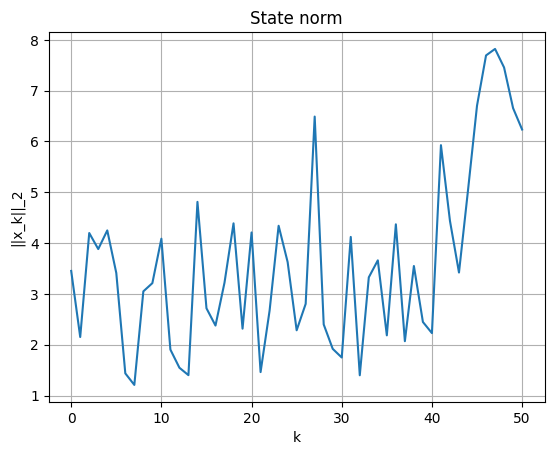

In [5]:
x_norm = np.linalg.norm(X, axis=1)
plt.figure()
plt.plot(x_norm)
plt.xlabel("k")
plt.ylabel("||x_k||_2")
plt.title("State norm")
plt.grid(True)
plt.show()

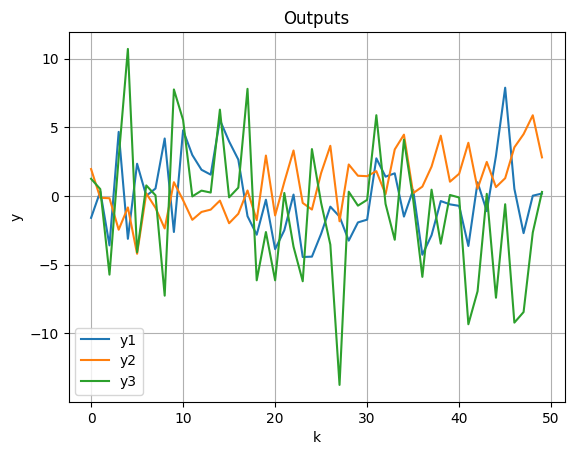

In [6]:
plt.figure()
for i in range(p):
    plt.plot(Y[:, i], label=f"y{i+1}")
plt.xlabel("k")
plt.ylabel("y")
plt.title("Outputs")
plt.legend()
plt.grid(True)
plt.show()

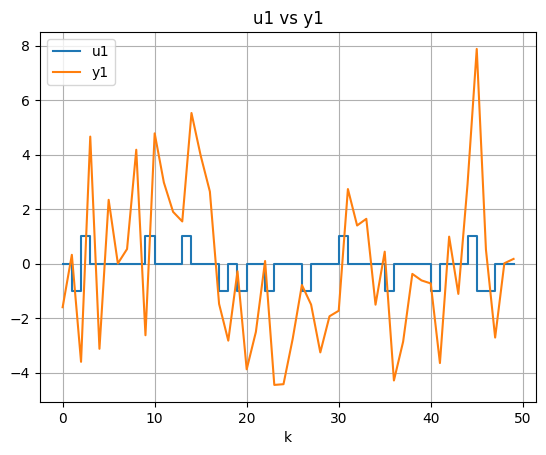

In [7]:
plt.figure()
plt.step(range(T), U[:, 0], where="post", label="u1")
plt.plot(Y[:, 0], label="y1")
plt.xlabel("k")
plt.title("u1 vs y1")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
observer_poles = np.random.uniform(0.1, 0.9, size=n)

from scipy.signal import place_poles
L = place_poles(A.T, C.T, observer_poles).gain_matrix.T

eig_err = np.linalg.eigvals(A - L @ C)
print("max |eig(A-LC)| =", np.max(np.abs(eig_err)))

max |eig(A-LC)| = 0.8924041135476959


In [9]:
def run_observer(A, B, C, D, L, Y, U, xhat0=None):
    T = Y.shape[0]
    n = A.shape[0]
    p = C.shape[0]
    m = U.shape[1]

    if xhat0 is None:
        xhat0 = np.zeros(n)

    Xhat = np.zeros((T+1, n))
    Yhat = np.zeros((T, p))
    Xhat[0] = xhat0

    for k in range(T):
        Yhat[k] = C @ Xhat[k] + D @ U[k]
        Xhat[k+1] = A @ Xhat[k] + B @ U[k] + L @ (Y[k] - Yhat[k])

    return Xhat, Yhat


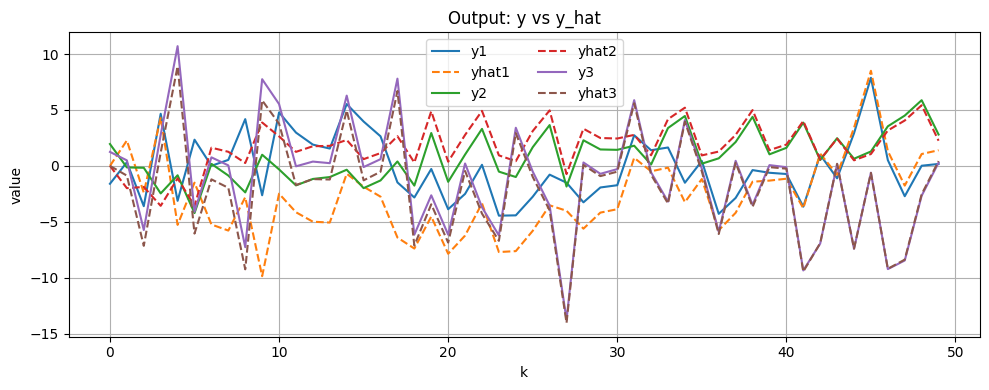

In [10]:
Xhat, Yhat = run_observer(A, B, C, D, L, Y, U)

t = np.arange(Y.shape[0])

plt.figure(figsize=(10, 4))
for i in range(Y.shape[1]):
    plt.plot(t, Y[:, i], label=f"y{i+1}")
    plt.plot(t, Yhat[:, i], "--", label=f"yhat{i+1}")
plt.xlabel("k")
plt.ylabel("value")
plt.title("Output: y vs y_hat")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

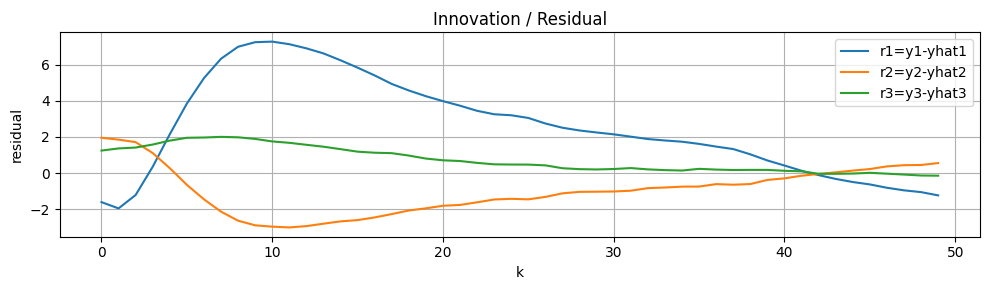

In [11]:
resid = Y - Yhat  # (T, p)

plt.figure(figsize=(10, 3))
for i in range(resid.shape[1]):
    plt.plot(resid[:, i], label=f"r{i+1}=y{i+1}-yhat{i+1}")
plt.xlabel("k")
plt.ylabel("residual")
plt.title("Innovation / Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


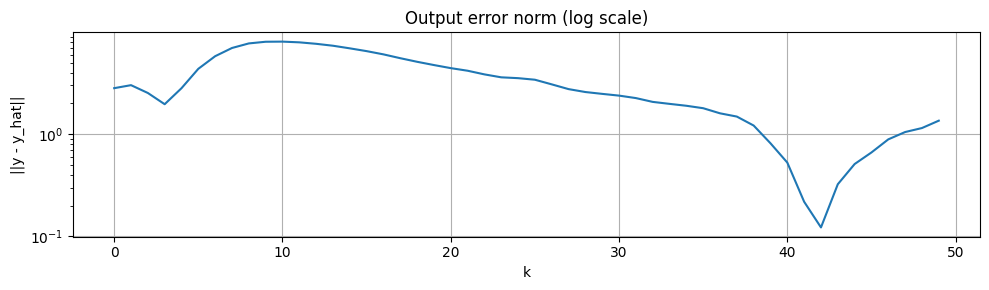

In [12]:
err_y = np.linalg.norm(resid, axis=1)

plt.figure(figsize=(10, 3))
plt.semilogy(err_y)
plt.xlabel("k")
plt.ylabel("||y - y_hat||")
plt.title("Output error norm (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


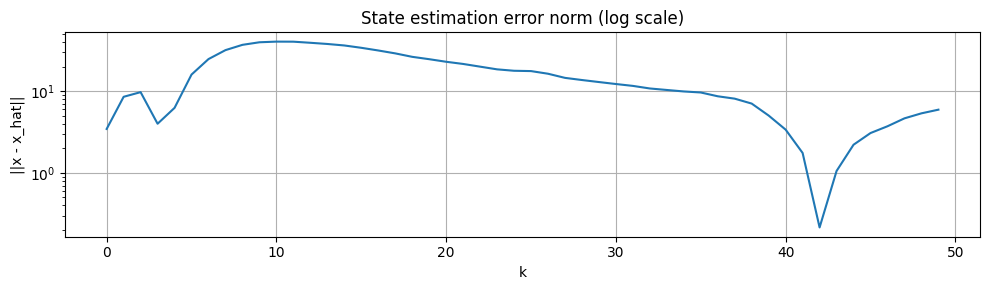

In [13]:
err_x = np.linalg.norm(X[0:-1] - Xhat[0:-1], axis=1)

plt.figure(figsize=(10, 3))
plt.semilogy(err_x)
plt.xlabel("k")
plt.ylabel("||x - x_hat||")
plt.title("State estimation error norm (log scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


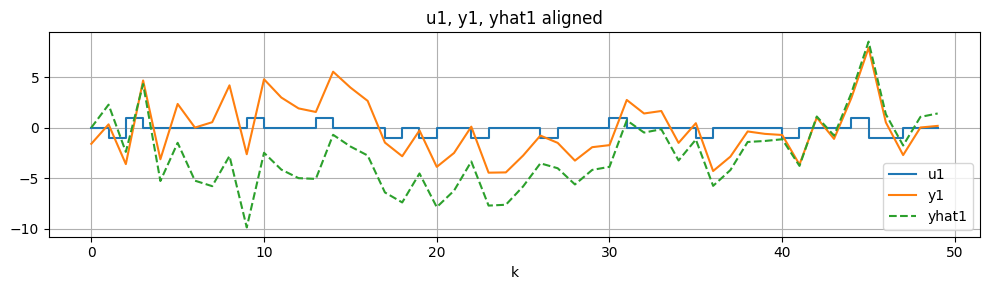

In [14]:
plt.figure(figsize=(10, 3))
plt.step(t, U[:, 0], where="post", label="u1")
plt.plot(t, Y[:, 0], label="y1")
plt.plot(t, Yhat[:, 0], "--", label="yhat1")
plt.xlabel("k")
plt.title("u1, y1, yhat1 aligned")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
